![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# **Feature Extraction From Beer Reviews**


### **Preliminaries**
#### We read in the allBeer.txt file and create an RDD consisting of lines.
#### We want to remove the header from the file, so the parseDataFileLine function identifies lines starting with 'beer_id' and applies a flag of 0, other lines with the correct number of fields are flagged 1, and incorrect lines are flagged -1.  The lines are split into arrays.

In [1]:
import re

def parseDatafileLine(datafileLine):
    ##Parse a line of the data file using the specified regular expression pattern
    splitArray = datafileLine.split("\t")
    for x in range(0,len(splitArray)):
        splitArray[x]=splitArray[x].replace("\"",'')
    #print len(splitArray)
    #print splitArray[0],splitArray[1],splitArray[2]
    if splitArray[0]=='beer_id':
        return (splitArray,0)
    elif len(splitArray)<>23:
        ##this is a failed parse
        return (splitArray,-1)
    else:
        return (splitArray, 1)

### Reading the file
#### We read the file into three rdds by first parsing the file as above, the header rdd, failed rdd and the valid rdd.  Print the header names so we can remember what fields we're dealing with and in what order.

In [2]:
import sys
import os

baseDir = os.path.join('')
allBeer_Path = 'AllBeer.txt'
STOPWORDS_PATH = 'stopwords.txt'

def parseData(filename):
    #Parse a data file returns a RDD of parsed lines
    
    return (sc
            .textFile(filename, 4, 0)
            .map(parseDatafileLine)
            .cache())

def loadData(path):
    ##Load a data file, returns a RDD of parsed valid lines
    
    filename = os.path.join(baseDir, path)
    raw = parseData(filename).cache()
    failed = (raw
              .filter(lambda s: s[1] == -1)
              .map(lambda s: s[0]))
    for line in failed.take(10):
        print '%s - Invalid datafile line: %s' % (path, line)
    valid = (raw
             .filter(lambda s: s[1] == 1)
             .map(lambda s: s[0])
             .cache())
    header = (raw
              .filter(lambda s: s[1]==0)
             .map(lambda s:s[0])
             )
    for line in header.take(1):
        for x in range(0,len(line)):
            print x,line[x]
            
    rawLines = raw.count()
    validLines = valid.count()
    failedLines = failed.count()
    print '%s - Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (path, rawLines, validLines,failedLines)
    return valid
    
allBeer = loadData(allBeer_Path)
#allReviews = loadData(allReviews_Path)

0 beer_id
1 beer_name
2 brewer_name
3 beer_style
4 distribution
5 brewery_location
6 commercial_desc
7 RATINGS: 
8 MEAN (/5)
9 WEIGHTED AVG
10 EST. CALORIES
11 ABV (%)
12 IBU
13 SCORE
14 AROMA (/10)
15 APPEARANCE(/5)
16 TASTE(/10)
17 PALATE(/5)
18 OVERALL(/20)
19 reviewer_name
20 review_location
21 review_date
22 review_content
AllBeer.txt - Read 240355 lines, successfully parsed 240354 lines, failed to parse 0 lines


### Let's examine the first few entries of a sample of 5 lines to check if things look ok.

In [3]:
sampleArray=allBeer.takeSample(False,5,1)
for line in sampleArray:
    print len(line)
    print 'allBeer: %s, %s, %s, %s, %s\n' % (line[0], line[1], line[2],line[3],line[4])

23
allBeer: 40920, Wernecker Haustrunk Pils, Wernecker Bierbrauerei, Pilsener, distribution unknown

23
allBeer: 21911, Au Ma'tre Brasseur La Boucaneuse, AMB - Ma'tre Brasseur, Smoked, distribution unknown

23
allBeer: 4991, New Albanian / Struise Naughty Girl, New Albanian Brewing Company, India Pale Ale (IPA), Regional Distribution

23
allBeer: 38430, BrewDog IPA is Dead - Pioneer, BrewDog, India Pale Ale (IPA), Broad Distribution

23
allBeer: 41353, Cascade Cerise Nouveau, Cascade Brewing, Sour/Wild Ale, Local Distribution



### Now we'll split the data into a training set (80%) and test set (%20).  
#### This is slightly complicated by the fact that we want to split each user into 80/20, not the set of reviews as a whole.  We will take advantage of stratified sampling in Spark, grouping the reviews by the user name, then sampling by key.  To get the unused data we employ subtractByKey using a compound key of the username and the beer_id, guaranting uniqueness.

In [4]:
##Using the allBeer array, take stratified sample, and remove blank reviews.
beerByUser = allBeer.map(lambda x:(x[19],x)).filter(lambda (x,y):y[22]!='')
sampleKeys = beerByUser.keys().collect()
fractions={}
for k in sampleKeys:
    fractions[k]=0.8
    
beerTrain = beerByUser.sampleByKey(False,fractions).cache()
beerTrainKeyed = beerTrain.map(lambda (x,y):(y[0]+y[19],y))
beerTest = allBeer.map(lambda x:(x[0]+x[19],x)).subtractByKey(beerTrainKeyed).map(lambda (x,y):(y[19],y)).cache()
print beerByUser.count()
print beerTrain.count()
print beerTest.count()

240334
192441
47913


### Let's examine the results with a couple of random users.

In [5]:
from numpy.random import random_integers
##find a random user and print out the train and test set.
randomUsers = random_integers(1,len(sampleKeys),2)
sampleUserReviewCount = beerByUser.filter(lambda (x,y):x==sampleKeys[randomUsers[0]]).count()
sampleUserTrainCount = beerTrain.filter(lambda (x,y):x==sampleKeys[randomUsers[0]]).count()
sampleUserTestCount = beerTest.filter(lambda (x,y):x==sampleKeys[randomUsers[0]]).count()
print "The user %s has %d reviews, split into %d Train and %d Test" % (sampleKeys[randomUsers[0]],sampleUserReviewCount,sampleUserTrainCount,sampleUserTestCount)

sampleUserReviewCount = beerByUser.filter(lambda (x,y):x==sampleKeys[randomUsers[1]]).count()
sampleUserTrainCount = beerTrain.filter(lambda (x,y):x==sampleKeys[randomUsers[1]]).count()
sampleUserTestCount = beerTest.filter(lambda (x,y):x==sampleKeys[randomUsers[1]]).count()
print "The user %s has %d reviews, split into %d Train and %d Test" % (sampleKeys[randomUsers[1]],sampleUserReviewCount,sampleUserTrainCount,sampleUserTestCount)

The user patricks110 has 79 reviews, split into 57 Train and 22 Test
The user slowrunner77 has 623 reviews, split into 489 Train and 134 Test


### Scale the reviews:
#### Each user has a different way of scoring beers, some people judge more harshly than others.  In order to even out these scores, we get get statistics for each user and adjust their scores to fit a common distribution.  In this particular case we use a normal distribution for it's simplicity to execute.  Users with 1 or less reviews will have a standard deviation of 0, in which case we substitute 1 to ensure the division when obtaining z-scores we will not divide by zero.

In [6]:
from math import sqrt
##13 SCORE
##14 AROMA (/10)
##15 APPEARANCE(/5)
##16 TASTE(/10)
##17 PALATE(/5)
##18 OVERALL(/20)

def replaceZeroes(inputValue,replacementValue):
    if inputValue == 0:
        inputValue = replacementValue
    return inputValue

def subtractFromColumn(inputList,columnToChange,subtractAmount):
    inputList[columnToChange]=float(inputList[columnToChange])-subtractAmount
    return inputList

def divideColumn(inputList,columnToChange,divisor):
    inputList[columnToChange]=float(inputList[columnToChange])/divisor
    return inputList


### rewrite this to be RDD of (key,everything else) and return (key, everything with normalized column x)
### Then run a few times and cache, and move this up into the preliminaries (post split)
def normalizeScoreByKey(inputRDD,scoreColumn):
    ##Takes in RDD of (key,array) and 
    ##returns RDD of (key,array with scoreColumn normalized)
    sumScores = inputRDD.map(lambda (x,y):(x,float(y[scoreColumn]))).reduceByKey(lambda a,b:a+b)
    #print sumScores.map(lambda (x,y):y).reduce(lambda a,b:a+b)
    countScoresPerKey = inputRDD.map(lambda (x,y):(x,1)).reduceByKey(lambda a,b:a+b)
    #print countKeys.map(lambda (x,y):y).reduce(lambda a,b:a+b)
    averageScores = sumScores.join(countScoresPerKey).map(lambda (x,y):(x,y[0]/y[1]))
    #print averageScores.takeSample(False,5,3)
    centredScores = inputRDD.join(averageScores).map(lambda (x,(y,z)):(x,subtractFromColumn(y,scoreColumn,z)))
    #print centredScores.map(lambda (x,y):y[scoreColumn]).reduce(lambda a,b:a+b)
    centredScoresSquaredSum = centredScores.map(lambda (x,y):(x,y[scoreColumn]*y[scoreColumn])).reduceByKey(lambda a,b:a+b)
    centredScoresSquaredSumAndCount = centredScoresSquaredSum.join(countScoresPerKey)
    stdDeviationByKey = centredScoresSquaredSumAndCount.map(lambda (x,y):(x,sqrt(y[0]/y[1])))
    ##This is actually pointless since a centred score is 0 and 0/anything = 0
    ##countLines = stdDeviationByUser.count()
    ##avgStdDev = stdDeviationByUser.map(lambda (x,y):y).reduce(lambda a,b:a+b)/countLines
    stdDeviationByKeyNoZero = stdDeviationByKey.map(lambda (x,y):(x,replaceZeroes(y,1)))
    normalizedRDD = centredScores.join(stdDeviationByKeyNoZero).map(lambda (x,(y,z)):(x,divideColumn(y,scoreColumn,z)))
    return normalizedRDD

##Normalize the Scores
normalizedScores = normalizeScoreByKey(beerTrain,13)
##Normalize the rest of the ratings
#beerTrainNormA = normalizeScoreByKey(normalizedScores,14)
#beerTrainNormB = normalizeScoreByKey(beerTrainNormA,15)
#beerTrainNormC = normalizeScoreByKey(beerTrainNormB,16)
#beerTrainNormD = normalizeScoreByKey(beerTrainNormC,17)
beerTrainNormalized = normalizeScoreByKey(normalizedScores,18).cache()

print beerTrainNormalized.takeSample(False,5,4)


[('Lubiere', ['22524', 'Brutopia Gold n Wheat', 'Brutopia', 'Wheat Ale', 'distribution unknown', 'Montreal, Canada', 'No commercial description', '6.000', '2.980', '2.870', '', '', '', -0.05648804325138059, '6.000', '3.000', '7.000', '3.000', 0.21007660350402088, 'Lubiere', 'Ottawa, Ontario, CANADA ', 'APR 3, 2004 ', 'Golden clear beer with a fresh malt and cookie nose, and a pleasant aroma of hops. Nice crisp matly taste with some lactic /milkery notes, with a touch of lemon, and the light hoips which linger on pleasantly. Medium body for a lighter beer. ']), ('adnielsen', ['26927', 'Hill Farmstead Genealogy of Morals - Bourbon', 'Hill Farmstead Brewery', 'Imperial Stout', 'Local Distribution', 'Greensboro , Vermont USA', 'An Imperial Stout brewed with Wheat and Coffee and aged in Bourbon barrels from our favorite distilleries...', '97.000', '', '4.110', '300.000', '10.000', '', 1.4296487759258447, '9.000', '4.000', '8.000', '4.000', 1.5272391508510978, 'adnielsen', 'Fort Collins, Col

### **Normalized Histograms**
#### Plot histograms of the normalized ratings to check to see if normality approximately holds.
#### Clearly score and overall are not normal, skewed right.  This would imply that when people hate a beer, they're more willing to review it harshly than they are willing to give a glowing review to a beer they love.

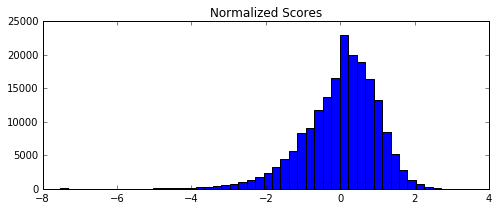

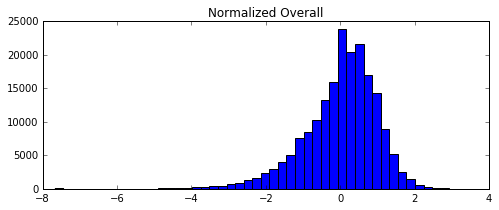

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
##Get all the normalized scores into one list.
scoreValues = beerTrainNormalized.map(lambda (x,y): y[13]).collect()
fig = plt.figure(figsize=(8,3))
plt.title('Normalized Scores')
plt.hist(scoreValues, 50, log=False)
overallValues = beerTrainNormalized.map(lambda (x,y): y[18]).collect()
fig = plt.figure(figsize=(8,3))
plt.title('Normalized Overall')
plt.hist(overallValues, 50, log=False)
pass

### Step 1: Making Bags of Words
#### We can take the commercial descriptions and the user input text reviews and convert them into bags of words, we can then treat each word as a feature.  
#### We should take out stopwords before we do this, to avoid unfairly weighting reviews based on words which don't contribute much meaning, such as "the", "a", "is", "which", etc.

In [8]:
stopfile = os.path.join(baseDir, STOPWORDS_PATH)
stopwords = set(sc.textFile(stopfile).collect())
testString = "This is a test of the tf function.  It should return non stopword frequencies frequency sourness"
print 'These are the stopwords: %s' % stopwords
split_regex = r'\W+'

#from nltk.stem.porter import PorterStemmer
#Stmmr = PorterStemmer()

def tokenize(string):
    ##takes in a string and tokenizes it, removing stopwords, returns list
    simple=filter(None,re.split(split_regex,string.lower()))
    #simple = [Stmmr.stem(i) for i in simple]
    return [i for i in simple if i not in stopwords]

print tokenize(testString)

These are the stopwords: set([u'all', u'just', u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'with', u'had', u'should', u'to', u'only', u'under', u'ours', u'has', u'do', u'them', u'his', u'very', u'they', u'not', u'during', u'now', u'him', u'nor', u'did', u'these', u't', u'each', u'where', u'because', u'doing', u'theirs', u'some', u'are', u'our', u'ourselves', u'out', u'what', u'for', u'below', u'does', u'above', u'between', u'she', u'be', u'we', u'after', u'here', u'hers', u'by', u'on', u'about', u'of', u'against', u's', u'or', u'own', u'into', u'yourself', u'down', u'your', u'from', u'her', u'whom', u'there', u'been', u'few', u'too', u'themselves', u'was', u'until', u'more', u'himself', u'that', u'but', u'off', u'herself', u'than', u'those', u'he', u'me', u'myself', u'this', u'up', u'will', u'while', u'can', u'were', u'my', u'and', u'then', u'is', u'in', u'am', u'it', u'an', u'as', u'itself', u'at', u'have', u'further', u'their', u'if', u'again', u'no', u

### **Tokenizing the Commercial Description and Review**
#### Now tokenize the commercial descriptions and reviews. 
#### To see how much data we're dealing with let's count the total number of tokens.

In [9]:
##6 commercial description
##22 user input review
##make an RDD where the user_id is the key, and the value is 2 arrays of tokens 
##and the original line
beerTrainToToken = beerTrainNormalized.map(lambda (x,y):(y[19],(tokenize(y[6]),tokenize(y[22]),y)))

def countTokens(textRDD,reviewTRUE):
    ## Count and return the number of tokens
    if reviewTRUE==True:
        return textRDD.map(lambda (x,y):len(y[1])).reduce(lambda a,b:a+b)
    else:
        return textRDD.map(lambda (x,y):len(y[0])).reduce(lambda a,b:a+b)

print 'There are %s tokens in the commercial descriptions' % countTokens(beerTrainToToken,False)
print 'There are %s tokens in the reviews' % countTokens(beerTrainToToken,True)

There are 4672914 tokens in the commercial descriptions
There are 6680826 tokens in the reviews


### Let's get an idea of how big a review is

In [10]:
def findBiggestRecord(textRDD,reviewTRUE):
    # Find and return the record with the largest number of tokens
    if reviewTRUE==True:
        return textRDD.takeOrdered(1,lambda (x,y):-len(y[1]))
    else:
        return textRDD.takeOrdered(1,lambda (x,y):-len(y[0]))

def findSmallestRecord(textRDD,reviewTRUE):
    # Find and return the record with the largest number of tokens
    if reviewTRUE==True:
        return textRDD.takeOrdered(1,lambda (x,y):len(y[1]))
    else:
        return textRDD.takeOrdered(1,lambda (x,y):len(y[0]))

biggestReview = findBiggestRecord(beerTrainToToken,True)
print 'The review from user "%s" has the most tokens (%s)' % (biggestReview[0][0],
                                                                   len(biggestReview[0][1][1]))
smallestReview = findSmallestRecord(beerTrainToToken,True)
print 'The review from user "%s" has the least tokens (%s)' % (smallestReview[0][0], len(smallestReview[0][1][1]))

The review from user "SlovakSniper" has the most tokens (579)
The review from user "Shurf" has the least tokens (0)


### So clearly we've got some reviews that are empty, and we'll need some special handling for those.

### **Step 2: Weighted Bag-of-Words using TF-IDF**

### Term Frequency (TF) 
#### This gives higher weight to tokens that appear many times in a individual document. It is computed as the frequency of a token in a document. If a word occurs often in a document, then it is more important to the meaning of the document.

In [11]:
testString = "This is a test of the tf function.  It should return non stopword frequencies"
def tf(tokens):
    ###Compute TF from list of tokens, return dictionary of word:tf
    count = len(tokens)
    words={}
    for token in tokens:
        words[token]=float(len([t for t in tokens if t==token]))/count
    return words

print tf(tokenize(testString))

{'function': 0.14285714285714285, 'non': 0.14285714285714285, 'return': 0.14285714285714285, 'frequencies': 0.14285714285714285, 'stopword': 0.14285714285714285, 'tf': 0.14285714285714285, 'test': 0.14285714285714285}


### Inverse Document Frequency
#### This gives higher weight to tokens that are rare over the entire dataset. The rationale is two documents are more alike if they have in common words which are not common to rest data set.  IDF weight for a token in a set of documents is calculated as D/d(t) where D is the total number of documents and d(t) is the number of documents with term t.  
#### Keep in mind that the dataset for IDF is not the whole dataset, but the set of reviews for a particular user.  We want to find out what is special to that individual.

In [12]:
def countEachToken(listOfTokens):
    ##Count the number of times each token appears in the list
    tokenSet = list(set(listOfTokens))
    tokenDict={}
    for token in tokenSet:
        tokenDict[token]=0
    for token in listOfTokens:
        tokenDict[token]=tokenDict[token]+1
    return tokenDict

def divideIntByDict(inputDict,inputInt):
    for entry in inputDict:
        inputDict[entry]=float(inputInt)/float(inputDict[entry])
    return inputDict


def IDFByKey(keyCorpus):
    uniqueTokens = keyCorpus.map(lambda (x,y):(x,list(set(y))))
    tokensByKey = uniqueTokens.reduceByKey(lambda a,b:a+b)
    tokensCountByKey = tokensByKey.map(lambda (x,y):(x,countEachToken(y)))
    countDocsByKey=keyCorpus.map(lambda (x,y):(x,1)).reduceByKey(lambda a,b:a+b)
    countDocsAndTokensByKey = tokensCountByKey.join(countDocsByKey)
    IDF=countDocsAndTokensByKey.map(lambda (x,y):(x,divideIntByDict(y[0],y[1])))
    return IDF

#RDD of (beer_id,text)
reviewTokens = beerTrainToToken.map(lambda (x,y):(x,y[1]))
reviewIDF=IDFByKey(reviewTokens)
print reviewIDF.takeSample(False,2,1)

[('Chrism86', {'shop': 9.0, 'summer': 9.0, 'interpretation': 9.0, 'stlye': 9.0, 'offensive': 9.0, 'bad': 9.0, 'cheap': 9.0, 'fizzy': 9.0, 'abit': 9.0, 'bring': 9.0, 'mild': 4.5, 'citrusy': 9.0, 'looks': 9.0, 'roasted': 4.5, 'go': 9.0, 'earth': 9.0, 'alternative': 9.0, 'still': 9.0, 'bock': 9.0, 'apple': 9.0, 'style': 4.5, '21': 9.0, 'faults': 9.0, 'hops': 9.0, 'interesting': 9.0, 'honey': 4.5, 'seems': 9.0, 'character': 9.0, 'actually': 9.0, 'going': 4.5, 'black': 9.0, 'easy': 9.0, '8': 9.0, 'toffee': 9.0, 'real': 4.5, 'brown': 4.5, 'updated': 2.25, 'good': 4.5, 'dominant': 9.0, 'abv': 9.0, 'citrus': 9.0, 'familiar': 9.0, 'astringent': 9.0, 'overall': 9.0, 'none': 4.5, 'coloured': 4.5, 'dark': 3.0, 'made': 4.5, 'fan': 9.0, 'know': 9.0, 'stout': 9.0, 'drinking': 9.0, 'like': 9.0, 'peculier': 9.0, 'd': 9.0, 'malt': 1.5, 'notes': 4.5, 'didn': 9.0, 'loosely': 9.0, 'biscuity': 9.0, 'lightning': 9.0, 'benefit': 9.0, 'caramel': 4.5, 'common': 9.0, 'roast': 9.0, 'nz': 9.0, 'enhance': 9.0, 'nic

### **Implement a TF-IDF function**
#### We want to weight the individual features (words) by the user's given scores.  This should increase the weightings of words used only in positive reviews and greatly increase rare words in positive reviews.  We then create an RDD of (key, dictionary) where the dictionary is a ranked collection of each user's individual preferences.  We have a customized set of features which indicate what a user likes.

#### We then sum across all users and reviews to get a weighted feature set which pushes important words to the top and bottom of the list and unimportant words to the middle.

In [13]:
def multiplyDict(inputDict,multiplier):
    #multiplies every entry in a dictionary by a number.
    for item in inputDict:
        inputDict[item]=inputDict[item]*multiplier
    return inputDict

def stf(tokens, score):
    ### Compute S-TF
    tfsDict = tf(tokens)
    stfsDict = multiplyDict(tfsDict,score)
    return stfsDict

def multiplyTwoDicts(firstDict,secondDict):
    multDict = {token:firstDict[token]*secondDict[token] for token in firstDict}
    return multDict

def addTwoDicts(firstDict,secondDict):
    for token in firstDict:
        if token in secondDict:
            firstDict[token]=firstDict[token]+secondDict[token]
    for token in secondDict:
        if token in firstDict:
            pass
        else:
            firstDict[token]=secondDict[token]            
    return firstDict

##13 SCORE
##14 AROMA (/10)
##15 APPEARANCE(/5)
##16 TASTE(/10)
##17 PALATE(/5)
##18 OVERALL(/20)

def stfidfByKey(inputRDD,idfRDD,reviewTrue,whichRating):
    ##Takes RDD of form (key,(list,list,wholebeer)) and calculates the s-tf of 
    ##reviewTrue==True ===> review
    ##reviewTrue==False ===> commercial Description
    ##whichRating ==-1 => don't weight by any column, just use 1 as a factor
    ##takes the sum of s-tf and applies the idf to it.
    
    if (whichRating < 13 or whichRating >18) and whichRating!=-1:
        raise ValueError('whichRating must be between 13 and 18 or equal to 0, please refer to documentation about fields')
                         
    if reviewTrue==True:
        #print "Got past true"
        #print inputRDD.map(lambda (x,(a,b,c)):(x,(b,c[whichRating]))).takeSample(False,3,1)
        if whichRating!=-1:
            stfRDD = inputRDD.map(lambda (x,(a,b,c)):(x,(stf(b,float(c[whichRating]))))).reduceByKey(addTwoDicts)
        else:
            stfRDD = inputRDD.map(lambda (x,(a,b,c)):(x,(stf(b,1)))).reduceByKey(addTwoDicts)
        #print stfRDD.takeSample(True,3,1)
    else:
        if whichRating!=-1:
            stfRDD = inputRDD.map(lambda (x,(a,b,c)):(x,(stf(a,float(c[whichRating]))))).reduceByKey(lambda a,b:a+b)
        else:
            stfRDD = inputRDD.map(lambda (x,(a,b,c)):(x,(stf(a,1)))).reduceByKey(lambda a,b:a+b)
            
    stfidfRDD=stfRDD.join(idfRDD).map(lambda (x,(y,z)):(x,multiplyTwoDicts(y,z)))
    #print stfidfRDD.takeSample(True,3,1)
    return stfidfRDD

    
#Generate dictionaries of ranked terms for each user individually.
scoreTfIdf = stfidfByKey(beerTrainToToken,reviewIDF,True,13)
##Find the best keywords across all users.
sumAllFeatures =scoreTfIdf.map(lambda (x,y):y).reduce(addTwoDicts)
#print sumAllFeatures.takeSample(False,3,1)

import operator
sorted_features = sorted(sumAllFeatures.items(), key=operator.itemgetter(1))
print "There are %d unique features in the reviews" % len(sorted_features)
print "The beer features which people hate the most are: "
print sorted_features[:20]
print "The beer features which people love the most are: "
print sorted_features[-20:]


There are 98393 unique features in the reviews
The beer features which people hate the most are: 
[('corn', -6941.209993744306), ('watery', -5850.66264894118), ('water', -4683.900004495215), ('lager', -4389.999520993852), ('bad', -4275.710757612451), ('metallic', -4223.9412930499275), ('bland', -3937.619330094755), ('cardboard', -3801.816296439873), ('nothing', -3673.6976828052298), ('boring', -3215.0573825990336), ('artificial', -2980.1133995228292), ('stale', -2966.6472415862), ('infected', -2921.4956123918155), ('weak', -2842.48224693424), ('grainy', -2826.1889529502555), ('pale', -2825.5800669934138), ('much', -2786.526829001184), ('weird', -2732.136911924141), ('awful', -2689.753985258856), ('unpleasant', -2645.9264146945657)]
The beer features which people love the most are: 
[('awesome', 2026.6487907496098), ('whiskey', 2029.6271022811795), ('great', 2047.5732642319715), ('grapefruit', 2078.4490199791044), ('complex', 2080.840894256015), ('full', 2088.7537960739724), ('balanced'

NameError: name 'path' is not defined

# Fantastic!
### By amalgamating people's individual love/hates we show here that our intuition lines up with the methodology taken so far.  A vanilla bourbon beer beats an infected watery beer.

In [15]:
featuresFileName = os.path.join(baseDir, "sortedFeatures.txt")
with open(featuresFileName, "w") as f:
    for feature in sorted_features:
        f.write(str(feature[0]))
        f.write(",")
        f.write(str(feature[1]))
        f.write("\n")